In [1]:
import torch
import numpy as np
import pandas as pd

In [3]:
#!export HSA_OVERRIDE_GFX_VERSION=10.3.0

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [3]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
model.cuda()

def get_embs(text):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embs = model_output.last_hidden_state[:, 0, :]
    embs = torch.nn.functional.normalize(embs)
    return embs[0].cpu().numpy()

C:\Users\yeril\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mode

In [73]:
get_embs('hi').shape

(312,)

In [4]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:# Euclidian
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),0)
    elif distance_metric==1:#cosine
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=0)
        norm = np.linalg.norm(embeddings1, axis=0) * np.linalg.norm(embeddings2, axis=0)
        similarity = dot / norm
        dist = np.arccos(similarity) / np.pi
    else:
        raise 'Undefined %d' % distance_metric
    return dist

def get_distance(id1, id2, metric=1):
    label1 = df['label'][id1] if type(id1) == int else str(id1)
    label2 = df['label'][id2] if type(id2) == int else str(id2)
    print(f'distance between {label1} and {label2}: {distance(get_embs(label1), get_embs(label2), distance_metric=metric)}')

In [2]:
#df = pd.read_csv("C:\\Users\\yeril\\Desktop\\111.csv", sep=';', names=['id', 'label'])
df = pd.read_csv("../../DL/prj/111.csv", sep=';', names=['id', 'label'])
df.head()

,id,label
0,304999800,"ПРОЧЕЕ МЯСО РЫБЫ (ВКЛЮЧАЯ ФАРШ), МОРОЖЕНЫЕ, РЫ..."
1,604909900,"РАСТЕНИЯ ЗАСУШЕННЫЕ, ОБРАБОТАННЫЕ АНТИСЕПТИКОМ..."
2,711400000,ОГУРЦЫ (КОРНИШОНЫ) КОНСЕРВИРОВАННЫЕ ДЛЯ КРАТКО...
3,712909000,"ОВОЩИ СУЩЕННЫЕ, ЧЕСНОК СУШЕННЫЙ ХЛОПЬЯ, МАРКИР..."
4,803901000,"БАНАНЫ СВЕЖИЕ, ЗЕЛЕНЫЕ, СОРТА ""CAVENDISH"", УПА..."


In [5]:
df2 = pd.read_csv("../../DL/prj/Codes.csv")
df2.head()

,Unnamed: 0,Code,ДТ - добавочный лист Гр. 31 Описание и характеристика товара
0,0,9620000009,ОПОРА ТИПА СТОЙКА СТАЛЬНАЯ ДЛЯ МОНТАЖА ПРОЖЕКТ...
1,1,9620000009,ШТАТИВЫ ДЛЯ ФОТОКАМЕР СБОРНЫЕ (НЕЛИТЫЕ) ИЗ МЕТ...
2,2,9620000009,ОПОРА ТИПА СТОЙКА СТАЛЬНАЯ ДЛЯ МОНТАЖА ПРОЖEКТ...
3,3,9620000009,ОПОРЫ ТИПА ШТАТИВЫ ДЛЯ ФОТОКАМЕР СБОРНЫЕ (HЕЛИ...
4,4,9620000009,ШТАТИВЫ ДЛЯ ФОТОКАМЕР СБОРНЫЕ (НЕЛИТЫЕ) ИЗ МЕТ...


In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21817 entries, 0 to 21816
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      21817 non-null  int64 
 1   label   21817 non-null  object
dtypes: int64(1), object(1)
memory usage: 341.0+ KB


In [17]:
df2.drop('Unnamed: 0', axis=1, inplace=True)

In [18]:
names = ['id', 'label']

In [21]:
df2.rename(columns={df2.columns[0]: 'id', df2.columns[1]: 'label'}, inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70589 entries, 0 to 70588
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      70589 non-null  int64 
 1   label   70589 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21817 entries, 0 to 21816
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      21817 non-null  int64 
 1   label   21817 non-null  object
dtypes: int64(1), object(1)
memory usage: 341.0+ KB


In [26]:
df = pd.concat([df, df2])

In [27]:
df['label'] = df['label'].str.lower()
df['label'] = df['label'].str.strip()
df['label'] = df['label'].str.replace(r'\s+', ' ')
df['label'] = df['label'].str.replace(r'[^\w\s]+', ' ')

/tmp/ipykernel_4925/970123699.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['label'] = df['label'].str.replace(r'\s+', ' ')
/tmp/ipykernel_4925/970123699.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['label'] = df['label'].str.replace(r'[^\w\s]+', ' ')


In [28]:
df['label'] = df['label'].str.replace(r'\bупакован.+', '')

/tmp/ipykernel_4925/350809219.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['label'] = df['label'].str.replace(r'\bупакован.+', '')


In [29]:
df['label'] = df['label'].str.replace(r'\bвсего.+шт.+', '')

/tmp/ipykernel_4925/1721232508.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['label'] = df['label'].str.replace(r'\bвсего.+шт.+', '')


In [30]:
len(df[df['label']==''])

0

In [31]:
len(df['id'].unique())

2616

In [36]:
len(df['label'].unique())

86511

In [33]:
df = df.drop_duplicates()

In [35]:
df = df[df['label'].notnull()]

In [37]:
ids = pd.Series(df['id'])
ids = ids.astype(str)

In [38]:
df['id'] = ids

In [39]:
#df[df['id']==304999800]
len(df.query("id.str.len() == 9"))

211

In [40]:
from tqdm import tqdm

In [42]:
g_id = []
#gg_id = []
for i, id in enumerate(tqdm(df['id'])):
    if len(id) == 10:
        g_id.append(str(id)[:4])
        #gg_id.append(str(id)[:2])
    else:
        g_id.append('0' + str(id)[:3])
        #gg_id.append('0' + str(id)[:1])
df['g_id'] = g_id
#df['gg_id'] = gg_id
#g_id[10:]

100%|███████████████████████████████████████████████████████| 87488/87488 [00:00<00:00, 2122504.24it/s]


In [43]:
len(df['g_id'].unique())

658

In [44]:
len(df)

87488

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87488 entries, 0 to 21816
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      87488 non-null  object
 1   label   87488 non-null  object
 2   g_id    87488 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB


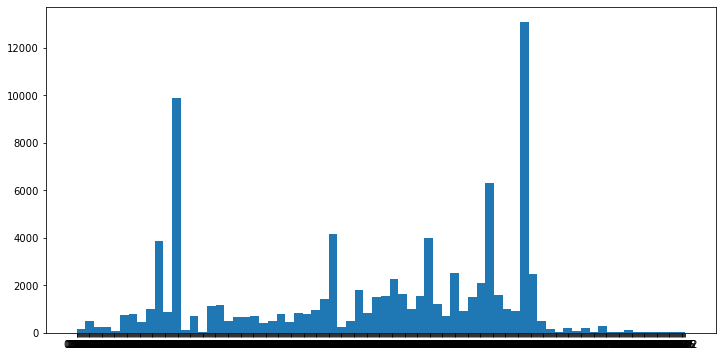

In [46]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(df['g_id'], 70)
plt.show()

In [20]:
embs = []
for i, label in enumerate(tqdm(df['label'])):
    embs.append(get_embs(label))
len(embs)

100%|███████████████████████████████████████████████████████████████████████████| 69958/69958 [05:14<00:00, 222.40it/s]


69958

In [21]:
df['emb'] = embs

In [22]:
df

,id,label,g_id,gg_id,emb
0,304999800,прочее мясо рыбы включая фарш мороженые рыб...,0304,03,"[0.02312238, -0.047608964, -0.026546676, -0.04..."
1,604909900,растения засушенные обработанные антисептиком...,0604,06,"[0.07274635, -0.06827808, 0.034841597, -0.1009..."
2,711400000,огурцы корнишоны консервированные для кратко...,0711,07,"[-0.02142443, -0.045624927, 0.02732854, -0.094..."
3,712909000,овощи сущенные чеснок сушенный хлопья маркир...,0712,07,"[0.059772942, -0.03212928, 0.040867265, -0.100..."
4,803901000,бананы свежие зеленые сорта cavendish упак...,0803,08,"[0.015860813, -0.07562457, 0.012571128, -0.070..."
...,...,...,...,...,...
70584,9617000001,термосы и вакуумные сосуды прочие в собранном ...,9617,96,"[-0.0034721876, 0.017499765, 0.04958394, -0.09..."
70585,9617000001,термосы и вакуумные сосуды прочие в собранном ...,9617,96,"[0.037946466, -0.0316441, 0.02204541, -0.08155..."
70586,9619008109,детские подгузники baby diaspers,9619,96,"[0.07619122, -0.03667876, 0.04221478, -0.06858..."
70587,9620000005,моноопоры двуноги треноги и аналогичные издели...,9620,96,"[0.0155068915, 0.00056217174, -0.005092197, -0..."


In [23]:
df.to_csv('../../tiny_embs_draft.csv')

In [49]:
#df_no_embs = df.drop(['emb', 'g_id', 'gg_id'], axis=1, inplace=False)
df = df.drop(['g_id'], axis=1, inplace=False)
df.to_csv('../../draft.csv')

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [30]:
y = df['g_id'].values
X = embs

In [31]:
knn = KNeighborsClassifier(n_neighbors=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
accuracy_score(y_test, preds)

0.8462454736039642

In [59]:
df['label'][df['g_id']==knn.predict(get_embs("шуруповерт").reshape(1, 312))[0]]

14779    6600125390 левый передний воздушный дефлектор ...
14780    8891752679 задний бампер верхняя часть в сборе...
14781    air deflector frt bumper lh левый воздушный де...
14782    front bumper lwr body front bumper lwr body ни...
14783    front bumper lwr body front bumper lwr body ни...
                               ...                        
69152    шрус с установочным комплектом  шрус  пыльник ...
69153    шрус с установочным комплектом  шрус  смазка  ...
69154    шрус с установочным комплектом пыльник  хомут ...
69155    шрус с установочным комплектом смазка  гайка п...
69156    шрус с установочным комплектом шрус  пыльник  ...
Name: label, Length: 6061, dtype: object